In [1]:
import yfinance as yf
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema
import matplotlib.colors as mcolors
from matplotlib.transforms import blended_transform_factory
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def search_stock_symbol(company_name):
    url = f'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={company_name}&apikey=Y9DN79N2PBBK2X1O'
    
    # Send request to Alpha Vantage API
    response = requests.get(url)
    data = response.json()
    
    # Extract and print best matches
    if 'bestMatches' in data:
        matches = data['bestMatches']
        for match in matches:
        
            if match['4. region'] == 'India/Bombay':
                symbol = match['1. symbol']
                name = match['2. name']

                return symbol,name

            else:
                continue
    
    else:
        
        raise ValueError("No such company found")

In [3]:
def symbol_changes(symbol):
    symbol = symbol[:-3]
    symbol += "NS"
    
    return symbol

In [4]:
# Calculate EPS and check for -ve growth (quartely-quartely yearly)
def pe_and_market_cap(all_info):
    
    share_price = all_info['currentPrice']
    no_shares = all_info['sharesOutstanding']
    eps = all_info['trailingEps']
    
    market_cap = share_price * no_shares
    pe = market_cap/ (eps * no_shares)
    
    if market_cap < (5000 * (10 **7)):
        Id ='s' #Small Cap

    elif (5000 * (10 ** 7)) < market_cap < 20000 * (10 ** 7):
        Id ='m' #Middle Cap

    else:
           Id ='l' #Large Cap
    
    if Id == 'l':
        id2 = 1
        
    else:
        id2 = 0
    
    return market_cap, pe, id2

In [5]:
def macd(data):
    ma12 = data['Close'].ewm(span=12, adjust=False).mean()
    ma26 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = ma12 - ma26
    signal_line = macd.ewm(span=9, adjust=False).mean()
    
    histogram = macd - signal_line
    
    data["MACD"] = macd
    data['Signal Line'] = signal_line
    data['Histogram'] = histogram
    
    # Calculate slopes for MACD and Signal Line
    data['MACD_slope'] = macd - macd.shift(1)
    data['Signal_slope'] = signal_line - signal_line.shift(1)
    
    # Initialize Signal column
    data['Signal'] = 0
    
    # Define conditions for Buy, Sell, and Hold
    buy_condition = (
        ((data['MACD'] > data['Signal Line']) & (data['MACD'].shift(1) <= data['Signal Line'].shift(1))) |  # Bullish crossover
        ((data['MACD_slope'] > 0) & (data['Signal_slope'] > 0))  # Both lines rising
    )
    
    sell_condition = (
        ((data['MACD'] < data['Signal Line']) & (data['MACD'].shift(1) >= data['Signal Line'].shift(1))) |  # Bearish crossover
        ((data['MACD_slope'] < 0) & (data['Signal_slope'] < 0))  # Both lines falling
    )
    
    # Apply conditions
    data.loc[buy_condition, 'Signal'] = 1
    data.loc[sell_condition, 'Signal'] = -1
    
    # Creating a column for prediction (Buy, Sell, or Hold)
    data['Prediction'] = data['Signal'].apply(lambda x: 'Buy' if x == 1 else ('Sell' if x == -1 else 'Hold'))
    
    return data[['Close', 'MACD', 'Signal Line', 'Histogram', 'MACD_slope', 'Signal_slope', 'Prediction']]

In [6]:
def rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Calculate initial average gains and losses
    avg_gain = gain[:window].mean()
    avg_loss = loss[:window].mean()
    
    # Initialize RSI values
    rsi_values = []
    
    # Iterate through the rest of the data
    for i in range(window, len(data)):
        avg_gain = (avg_gain * (window - 1) + gain.iloc[i]) / window
        avg_loss = (avg_loss * (window - 1) + loss.iloc[i]) / window
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        
        rsi_values.append(rsi)
    
    # Add RSI column to the DataFrame
    data['RSI'] = pd.Series(rsi_values, index=data.index[window:])
    
    return data[window:], window

In [7]:
# # Not giving the right answer
# def lifetime_high(company_name):
    
#     symbol = inp(company_name)
#     comp = yf.Ticker(symbol)
#     data = comp.history(period='1y', interval='1d')
    
#     return round(data['High'].max(), 3)

In [8]:
def fibonacci_retracement(data, window_size=10):
    close_prices = data['Close'].values
    
    # Function to identify trends
    def identify_trend(prices, window):
        trends = np.zeros(len(prices))
        for i in range(window, len(prices)):
            if prices[i] > prices[i-window]:
                trends[i] = 1  # Uptrend
            elif prices[i] < prices[i-window]:
                trends[i] = -1  # Downtrend
        return trends
    
    # Identify trends
    trends = identify_trend(close_prices, window_size)
    
    # Find the most recent significant trend change
    trend_changes = np.diff(trends)
    significant_changes = np.where(np.abs(trend_changes) > 0)[0]
    
    if len(significant_changes) > 0:
        last_change = significant_changes[-1]
        current_trend = "uptrend" if trends[last_change + 1] == 1 else "downtrend"
        
        # Find high and low prices since the trend change
        if current_trend == "uptrend":
            low_price = np.min(close_prices[max(0, last_change-window_size):last_change+1])
            high_price = np.max(close_prices[last_change+1:])
        else:
            high_price = np.max(close_prices[max(0, last_change-window_size):last_change+1])
            low_price = np.min(close_prices[last_change+1:])
    else:
        # If no significant trend change, use the entire dataset
        current_trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)
    
    # Ensure we have valid high and low prices
    if high_price == low_price:
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)
        current_trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
    
    # Calculate Fibonacci levels
    diff = high_price - low_price
    retracement_levels = {
        "23.6%": high_price - 0.236 * diff if current_trend == "uptrend" else low_price + 0.236 * diff,
        "38.2%": high_price - 0.382 * diff if current_trend == "uptrend" else low_price + 0.382 * diff,
        "50%": high_price - 0.500 * diff if current_trend == "uptrend" else low_price + 0.500 * diff,
        "61.8%": high_price - 0.618 * diff if current_trend == "uptrend" else low_price + 0.618 * diff,
        "78.6%": high_price - 0.786 * diff if current_trend == "uptrend" else low_price + 0.786 * diff
    }
    
    extension_levels = {
        "123.6%": high_price + 0.236 * diff,
        "138.2%": high_price + 0.382 * diff,
        "150%": high_price + 0.500 * diff,
        "161.8%": high_price + 0.618 * diff,
        "200%": high_price + diff,
    }
    
    return {
        "trend": current_trend,
        "prices": {
            "high_price": high_price,
            "low_price": low_price
        },
        "retracement_levels": retracement_levels,
        "extension_levels": extension_levels,
    }

In [9]:
def calculate_trend(df, window=14):
    # Higher Highs (HH) and Lower Highs (LH)
    df['Rolling_Max_High'] = df['High'].rolling(window=window).max()
    df['HH'] = df['High'] > df['Rolling_Max_High'].shift(1)
    df['LH'] = df['High'] < df['Rolling_Max_High'].shift(1)
    
    # Higher Lows (HL) and Lower Lows (LL)
    df['Rolling_Min_Low'] = df['Low'].rolling(window=window).min()
    df['HL'] = df['Low'] > df['Rolling_Min_Low'].shift(1)
    df['LL'] = df['Low'] < df['Rolling_Min_Low'].shift(1)
    
    df['Bullish_Strength'] = (df['HH'].rolling(window=window).sum() + 
                              df['HL'].rolling(window=window).sum()) / (2 * window)
    df['Bearish_Strength'] = (df['LH'].rolling(window=window).sum() + 
                              df['LL'].rolling(window=window).sum()) / (2 * window)
    return df[window:]

In [10]:
def interpret_macd(data):
    result = data.iloc[-1]
    
    pred = result['Prediction']
    macd_value = result['MACD']
    signal_value = result['Signal Line']
    histogram = result['Histogram']
    macd_slope = result['MACD_slope']
    signal_slope = result['Signal_slope']
    
    if pred == 'Buy':
        if macd_value > signal_value and macd_slope > 0 and signal_slope > 0:
            macd_response = "Strong Buy: MACD is above Signal Line and both are rising."
            macd_score = 1
        elif macd_value > signal_value:
            macd_response = "Buy: MACD has just crossed above the Signal Line."
            macd_score = 0.5
        else:
            macd_response = "Weak Buy: MACD and Signal Line are rising, but MACD is still below Signal Line."
            macd_score = 0.25
    
    elif pred == 'Sell':
       
        if macd_value < signal_value and macd_slope < 0 and signal_slope < 0:
            macd_response = "Strong Sell: MACD is below Signal Line and both are falling."
            macd_score = -1
        elif macd_value < signal_value:
            macd_response = "Sell: MACD has just crossed below the Signal Line."
            macd_score = -0.5
        else:
            macd_response = "Weak Sell: MACD and Signal Line are falling, but MACD is still above Signal Line."
            macd_score = 0.25
    
    else:  # Hold
        if histogram > 0:
            if macd_slope > 0 and signal_slope > 0:
                macd_response = "Hold (Bullish): MACD is above Signal Line and both are rising, but no crossover yet."
                macd_score = 0.25
            elif macd_slope < 0 and signal_slope < 0:
                macd_response = "Hold (Bearish Divergence): MACD is above Signal Line but both are falling."
                macd_score = -0.25
            else:
                macd_response = "Hold: MACD is above Signal Line but trend is unclear."
                macd_score = 0
        else:
            if macd_slope < 0 and signal_slope < 0:
                macd_response = "Hold (Bearish): MACD is below Signal Line and both are falling, but no crossover yet."
                macd_score = 0.25
            elif macd_slope > 0 and signal_slope > 0:
                macd_response = "Hold (Bullish Divergence): MACD is below Signal Line but both are rising."
                macd_score = 0.25
            else:
                macd_response = "Hold: MACD is below Signal Line but trend is unclear."
                macd_score = 0
    
    return macd_score, macd_response

In [11]:
def analyze_rsi(data):
    rsi_value = data['RSI']
    current_rsi = rsi_value.iloc[-1]
    prev_rsi = rsi_value.iloc[-2]
    rsi_change = current_rsi - prev_rsi

    if current_rsi > 70:
        if rsi_change > 0:
            rsi_score = -1  # Strong Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising, indicating strong overbought conditions. Consider SELLING.'
        else:
            rsi_score = -0.75  # Moderate Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} but decreasing, suggesting potential reversal from overbought conditions. Monitor closely for selling opportunities.'

    elif 70 >= current_rsi > 60:
        if rsi_change > 0:
            rsi_score = -0.5  # Mild Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising towards overbought territory. Consider selling or holding for some more time before selling .'
        else:
            rsi_score = -0.25  # Weak Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} but decreasing, moving away from overbought levels. Hold positions but stay cautious.'

    elif 60 >= current_rsi > 50:
        if rsi_change > 0:
            rsi_score = 0.25  # Weak Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising, showing increasing bullish momentum. Consider BUYING.'
        else:
            rsi_score = -0.25  # Weak Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} but decreasing, indicating weakening bullish momentum. Hold current positions.'

    elif 50 >= current_rsi > 40:
        if rsi_change > 0:
            rsi_score = 0.25  # Weak Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising, showing potential recovery from bearish territory. Monitor for buying opportunities.'
        else:
            rsi_score = -0.25  # Weak Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} and decreasing, moving towards oversold levels. Hold current positions and watch for further decline to buy.'

    elif 40 >= current_rsi > 30:
        if rsi_change > 0:
            rsi_score = 0.5  # Mild Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising from oversold levels. Consider initiating buying.'
        else:
            rsi_score = 0.25  # Weak Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and approaching oversold territory. Prepare for buying opportunities.'

    else:  # RSI <= 30
        if rsi_change > 0:
            rsi_score = 0.75  # Moderate Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising from oversold conditions. Strong buying opportunity, but be aware of potential false signals.'
        else:
            rsi_score = 1  # Strong Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and still decreasing in oversold territory. Very strong buy signal, but confirm with other indicators.'

    return rsi_score, rsi_response

In [33]:
def fib_insight(current_price, levels, trend, previous_price):
    insights = []
    weight = 0.5  # Start with a neutral weight
    
    def get_nearest_levels(price, level_dict):
        sorted_levels = sorted(level_dict.items(), key=lambda x: x[1])
        below = next(((name, value) for name, value in reversed(sorted_levels) if value < price), None)
        above = next(((name, value) for name, value in sorted_levels if value > price), None)
        return below, above

    def calculate_slope(price1, price2):
        return (price2 - price1) / price1

    slope = calculate_slope(previous_price, current_price)
    
    if trend == 'uptrend':
        below, above = get_nearest_levels(current_price, levels['extension'])
        
        if below and above:
            below_name, below_value = below
            above_name, above_value = above
            progress = (current_price - below_value) / (above_value - below_value)
            insights.append(f"Price is between {below_name} ({round(below_value, 2)}) and {above_name} ({round(above_value, 2)}) extension levels.")
            insights.append(f"Current price has retraced {round(progress * 100, 2)}% of the distance between these levels.")
            
            if slope > 0:
                insights.append(f"Price is trending upwards towards {above_name} level. Recommendation: Hold and Buy in the future when the oppurtunity turns up.")
                weight = min(weight + 0.1, 1)
            else:
                insights.append(f"Price is trending downwards towards {below_name} level. Recommendation: Buy in the future when the oppurtunity turns up")
                weight = max(weight - 0.1, 0)
            
            if progress < 0.2:
                insights.append(f"Price is close to {below_name} level, may act as support.")
                weight = min(weight + 0.1, 1)
            elif progress > 0.8:
                insights.append(f"Price is approaching {above_name} level, may face resistance.")
                weight = max(weight - 0.1, 0)
        
        for level_name, level_value in levels['extension'].items():
            price_diff_percent = (current_price - level_value) / level_value * 100
            if abs(price_diff_percent) <= 1:  # Within 1% of a level
                insights.append(f"Price is very close to {level_name} extension level ({round(level_value, 2)}), indicating potential resistance.")
                if slope > 0:
                    insights.append("Price is moving upwards. Recommendation: Hold.")
                    weight = max(weight - 0.2, 0)
                else:
                    insights.append("Price is moving downwards. Recommendation: Look for an oppturnity to Buy in the future.")
                    weight = min(weight + 0.1, 1)
            elif price_diff_percent > 1:  # Above a level
                weight = min(weight + 0.05 * (1 - price_diff_percent / 10), 1)  # Gradual weight increase
            
    elif trend == 'downtrend':
        below, above = get_nearest_levels(current_price, levels['retracement'])
        
        if below and above:
            below_name, below_value = below
            above_name, above_value = above
            progress = (current_price - below_value) / (above_value - below_value)
            insights.append(f"Price is between {below_name} ({round(below_value, 2)}) and {above_name} ({round(above_value, 2)}) retracement levels.")
            insights.append(f"Current price has retraced {round(progress * 100, 2)}% of the distance between these levels.")
            
            if slope > 0:
                insights.append(f"Price is trending upwards towards {above_name} level. Recommendation: Hold or Buy in the future when the oppurtunity turns up.")
                weight = min(weight + 0.1, 1)
            else:
                insights.append(f"Price is trending downwards towards {below_name} level. Recommendation: Buy in the future when the oppurtunity turns up.")
                weight = max(weight - 0.1, 0)
            
            if progress < 0.2:
                insights.append(f"Price is close to {below_name} level, may act as support.")
                weight = min(weight + 0.1, 1)
            elif progress > 0.8:
                insights.append(f"Price is approaching {above_name} level, may face resistance.")
                weight = max(weight - 0.1, 0)
        
        for level_name, level_value in levels['retracement'].items():
            price_diff_percent = (current_price - level_value) / level_value * 100
            if abs(price_diff_percent) <= 1:  # Within 1% of a level
                insights.append(f"Price is very close to {level_name} retracement level ({round(level_value, 2)}), indicating potential support.")
                if slope > 0:
                    insights.append("Price is moving upwards. Recommendation: Hold or Sell in the future when the oppurtunity turns up.")
                    weight = min(weight + 0.2, 1)
                else:
                    insights.append("Price is moving downwards. Recommendation:Sell in the future when the oppurtunity turns up.")
                    weight = max(weight - 0.1, 0)
            elif price_diff_percent < -1:  # Below a level
                weight = max(weight - 0.05 * (1 + price_diff_percent / 10), 0)  # Gradual weight decrease

    # Add overall trend insight based on slope
    if slope > 0:
        insights.append(f"Overall, price is trending upwards. Recommendation: Hold or Buy in the future when the oppurtunity turns up.")
        weight = min(weight + 0.1, 1)
    elif slope < 0:
        insights.append(f"Overall, price is trending downwards. Recommendation: Buy in the future when the oppurtunity turns up.")
        weight = max(weight - 0.1, 0)
    else:
        insights.append("Price is currently stable with no significant movement. Recommendation: Hold.")

    return insights, weight

In [52]:
def visualise_fib(d, data):
    high = d["prices"]['high_price']
    low = d["prices"]['low_price']
    trend = d["trend"]
    
    retracement_levels = d['retracement_levels']
    extension_levels = d['extension_levels']
    
    trend_start_date = data.index[data['Close'] == low][0]
    trend_end_date = data.index[data['Close'] == high][0]
    
    sorted_retracement = sorted(retracement_levels.items(), key=lambda x: float(x[0].strip('%')))
    sorted_extension = sorted(extension_levels.items(), key=lambda x: float(x[0].strip('%')), reverse=True)
    sorted_levels = sorted_extension + sorted_retracement
    
    extension_colors = ['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9']  # Red, Orange, Yellow, Green, Blue
    retracement_colors = ['#B10DC9', '#F012BE', '#85144b', '#001f3f', '#39CCCC']  # Purple, Pink, Maroon, Navy, Teal
    
    colors = extension_colors[:len(extension_levels)] + retracement_colors[:len(retracement_levels)]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    hover_template = "<b>Date:</b> %{x|%d %b %y}<br><b>Close:</b> %{y:.2f}<extra></extra>"
    fig.add_trace(go.Scatter(
        x=data.index, 
        y=data['Close'], 
        name='Close Price', 
        line=dict(color='#1e90ff', width=3),
        hovertemplate=hover_template
    ))
    
    # Add trend area
#     fig.add_trace(go.Scatter(x=[trend_start_date, trend_start_date, trend_end_date, trend_end_date],
#                              y=[data['Close'].min(), data['Close'].max(), data['Close'].max(), data['Close'].min()],
#                              fill='toself',
#                              fillcolor='rgba(255,255,0,0.3)',
#                              line=dict(color='rgba(255,255,0,0)'),
#                              name='Trend Area'))
    
    # Add Fibonacci levels
    for i, (label, level) in enumerate(sorted_levels):
        color = colors[i]
        dash = 'dash' if label in retracement_levels else 'dot'
        fig.add_trace(go.Scatter(x=[data.index[0], data.index[-1]], y=[level, level],
                                 mode='lines',
                                 name=f'{label} ({round(level, 2)})',
                                 line=dict(color=color, width=2, dash=dash)))
        
        # Add level badges
        fig.add_annotation(x=data.index[-1], y=level,
                           text=f'{label} ({round(level, 2)})',
                           showarrow=False,
                           xanchor='left',
                           xshift=10,
                           font=dict(color=color, size=10),
                           bgcolor='white',
                           bordercolor=color,
                           borderwidth=2,
                           borderpad=4,
                           opacity=0.8)
    
    # Update layout
    fig.update_layout(
        title='Fibonacci Retracement and Extension Levels',
        xaxis_title='Date',
        yaxis_title='Price',
        legend_title='Levels',
        hovermode='x unified',
        xaxis=dict(
            tickformat='%d %b %y',  # Updated date format
            tickangle=45,
            range=[data.index[-180], data.index[-1] + pd.Timedelta(days=20)],
            tickmode='array',
            tickvals=pd.date_range(start=data.index[-180], end=data.index[-1], freq='MS'),  # Monthly ticks
            ticktext=pd.date_range(start=data.index[-180], end=data.index[-1], freq='MS').strftime('%d %b %y')  # Formatted tick labels
        ),
        showlegend=True
    )
    
    fig.update_yaxes(tickformat='.2f')
    
    return fig

In [51]:
fig = visualise_fib_plotly(fib, data)
fig.show()

In [14]:
def visualise_macd(data):
    
    valid_data = data.dropna(subset=['MACD', 'Signal Line'])
    
    fig, ax1 = plt.subplots(1, figsize=(12,8))
    
    plt.style.use('ggplot')
    
    # Change colors to more pleasing options
    macd_color = '#1e90ff'  # Dodger Blue
    signal_color = '#ff6347'  # Tomato
    
    # Plot MACD and Signal lines
    ax1.plot(valid_data.index, valid_data['MACD'], label='MACD', color=macd_color, linewidth=1.5)
    ax1.plot(valid_data.index, valid_data['Signal Line'], label='Signal Line', color=signal_color, linestyle='--', linewidth=1.5)
    
    # Improve histogram appearance using fill_between instead of bar
    histogram = valid_data['MACD'] - valid_data['Signal Line']
    ax1.fill_between(valid_data.index, histogram, 0, where=histogram >= 0, facecolor='#2ecc71', alpha=0.7, interpolate=True, label='Positive Histogram')
    ax1.fill_between(valid_data.index, histogram, 0, where=histogram < 0, facecolor='#e74c3c', alpha=0.7, interpolate=True, label='Negative Histogram')
    
    # Enhance the legend
    ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    
    # Improve x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45, ha='right')
    
    # Adding extra days
    extra_days = pd.Timedelta(days=20)
    ax1.set_xlim(data.index[0], data.index[-1]+extra_days)
    
    # Set title and labels
    ax1.set_title("MACD Indicator", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("MACD Value", fontsize=12)
    
    
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()

In [15]:
def visualise_rsi(data, window):
    fig = go.Figure()

    # Add the RSI line
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['RSI'],
        mode='lines',
        name='RSI',
        line=dict(color='dodgerblue', width=2),
        hovertemplate='Date: %{x|%b %d}<br>RSI: %{y:.2f}<extra></extra>'
    ))

    # Add threshold lines for overbought (70) and oversold (30)
    fig.add_hline(y=70, line_dash="dash", line_color="red", line_width=2)
    fig.add_hline(y=30, line_dash="dash", line_color="green", line_width=2)

    # Set axis labels and title
    fig.update_layout(
        title="RSI (Relative Strength Index)",
        yaxis_title="RSI Value",
        xaxis_title="Date",
        font=dict(size=14),
        showlegend=True,
        legend=dict(x=0.01, y=0.99, font=dict(size=12)),
        hovermode="x unified",
    )

    # Set y-axis range and tick values
    fig.update_yaxes(
        range=[0, 100],
        tickmode='linear',
        tick0=0,
        dtick=10
    )

    # Set x-axis range and tick format
    extra_days = pd.Timedelta(days=20)
    fig.update_xaxes(
        range=[data.index[window-2], data.index[-1]+extra_days],
        tickmode='auto',
        nticks=10
    )

    # Update the layout for a cleaner look
    fig.update_layout(
        plot_bgcolor='white',
        xaxis=dict(
            showgrid=True,
            zeroline=False,
            showline=True,
            showticklabels=True,
        ),
        yaxis=dict(
            showgrid=True,
            zeroline=False,
            showline=True,
            showticklabels=True,
        )
    )

    # Show the plot
    fig.show()

In [16]:
def plot_stock_trends_candlestick(df):
    # Create the candlestick chart
    fig = go.Figure(data=[go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        increasing_line_color='#26A69A',  # Green color for up candles
        decreasing_line_color='#EF5350',  # Red color for down candles
        line=dict(width=1),  # Thinner lines for candle wicks
        increasing_fillcolor='#26A69A',  # Fill color for up candles
        decreasing_fillcolor='#EF5350'   # Fill color for down candles
    )])

    # Update layout for a cleaner look
    fig.update_layout(
        title='Candle Chart',
        yaxis_title= 'Price', 
        xaxis_title='Date',  
        xaxis_rangeslider_visible=False,
        plot_bgcolor='white',
        hovermode='x unified',
        showlegend=False, 
        margin=dict(l=0, r=0, t=0, b=0)  # Remove margins
    )

    # Update y-axis
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgrey',
        zeroline=False,
        showticklabels=True
    )

    # Update x-axis
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgrey',
        zeroline=False,
        rangeslider_visible=False,
        showticklabels=True,
        rangebreaks=[dict(bounds=["sat", "mon"])]  # hide weekends
    )

    fig.show() 

In [17]:
import warnings
warnings.filterwarnings('ignore')

Enter a name: tata steel

Buy stocks of Tata Steel Limited
Current Price of Tata Steel Limited: 159.65
Market Cap of Tata Steel Limited: 199299.08 Crores
The P/E ratio is -47.37, which is below 20, hence BUY


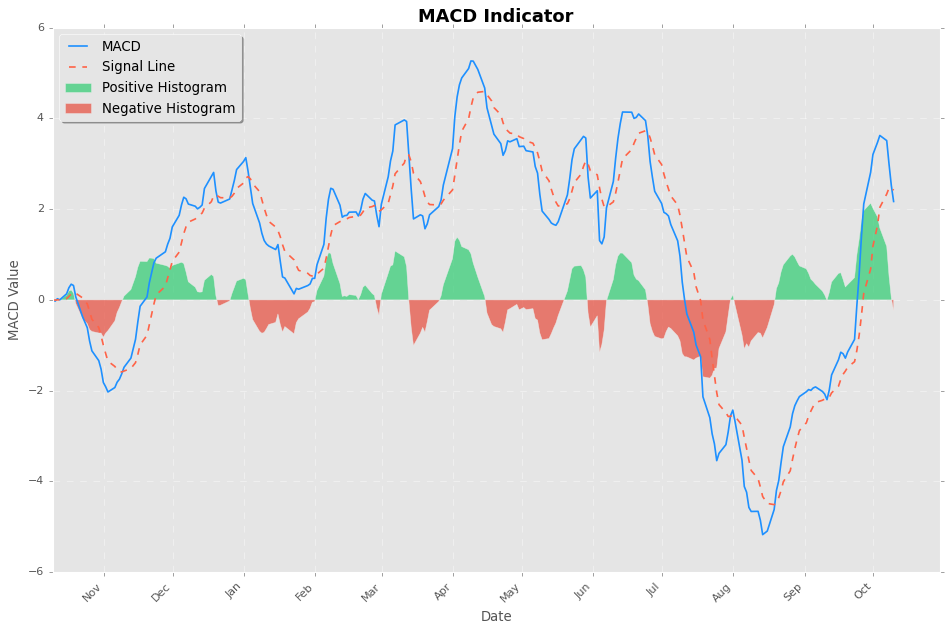

Strong Sell: MACD is below Signal Line and both are falling.


RSI is 51.09 and rising, showing increasing bullish momentum. Consider BUYING.


Overall, price is trending upwards. Recommendation: Hold or Buy in the future when the oppurtunity turns up.


In [100]:
#INPUT
name = input('Enter a name: ')

# PREPROCESSING THE NAME
symbol,st_name = search_stock_symbol(name)
symbol = symbol_changes(symbol)

# API CALL
comp = yf.Ticker(symbol)
data = comp.history(period='1y', interval='1d')
info = comp.info

curr_price = info['currentPrice']

weights = {
    'pe': 0.3,
    'rsi': 0.5,
    'macd': 0.5,
    'fib': 0.4
}

# PE RATIO AND CAP ID
info = pe_and_market_cap(info)

if info[2] != 1:
    print('The company is not large cap')
    

pe = info[1]

if pe <= 20:
    pe_score = 1  # Buy
    pe_response = f'The P/E ratio is {round(pe,2)}, which is below 20, hence BUY'

else:
    pe_score = -1  # Sell
    pe_response = f'The P/E ratio is {round(pe,2)}, which is above 20, hence SELL'


# RSI
r, window = rsi(data)
rsi_score, rsi_response = analyze_rsi(r)

# MACD
ma = macd(data)
macd_score, macd_response = interpret_macd(ma)


# Fibonacci Retracement
fib = fibonacci_retracement(data)

current_price = data['Close'].iloc[-1]
prev_price = data['Close'].iloc[-2]

trend = fib['trend']

levels = dict()
levels['retracement'] = fib['retracement_levels']
levels ['extension'] = fib['extension_levels']

fib_response, fib_score = fib_insight(current_price=current_price, trend=trend, levels=levels, previous_price=prev_price)


final_score = (pe_score * weights['pe']) + (rsi_score * weights['rsi']) + (macd_score * weights['macd']) + (fib_score * weights['fib'])

# Decision based on final score
if final_score > 0:
    print(f'\nBuy stocks of {st_name}')
else:
    print(f'\nSell your stocks of {st_name}')


print(f'Current Price of {st_name}: {curr_price}')
print(f'Market Cap of {st_name}: {round(info[0] / (10 ** 7) , 2)} Crores')

print(pe_response)  

visualise_macd(ma)
print(macd_response)

visualise_rsi(r, window)
print(rsi_response)

fig = visualise_fib(fib, data)
fig.show()
print(*fib_response)

In [55]:
a = calculate_trend(data)

In [67]:
plot_stock_trends_candlestick(a)

<center> <h1>BACKTESTING</h1> </center>

In [68]:
def calculate_signal(symbol, data, current_date):
    # Slice the data up to the current date
    current_data = data.loc[:current_date]
    
    # Get the latest info
    comp = yf.Ticker(symbol)
    info = comp.info
    
    curr_price = current_data['Close'].iloc[-1]
    
    weights = {
        'pe': 0.3,
        'rsi': 0.5,
        'macd': 0.5,
        'fib': 0.4
    }
    
    # PE RATIO AND CAP ID
    market_cap, pe, is_large_cap = pe_and_market_cap(info)
    
    if not is_large_cap:
        return 0  
    
    if pe <= 20:
        pe_score = 1  # Buy
    else:
        pe_score = -1  # Sell
    
    # RSI
    r, window = rsi(current_data)
    rsi_score, _ = analyze_rsi(r)
    
    # MACD
    ma = macd(current_data)
    macd_score, _ = interpret_macd(ma)
    
    # Fibonacci Retracement
    fib = fibonacci_retracement(current_data)
    current_price = current_data['Close'].iloc[-1]
    prev_price = current_data['Close'].iloc[-2]
    trend = fib['trend']
    levels = {
        'retracement': fib['retracement_levels'],
        'extension': fib['extension_levels']
    }
    _, fib_score = fib_insight(current_price=current_price, trend=trend, levels=levels,previous_price=prev_price)

    final_score = (pe_score * weights['pe']) + (rsi_score * weights['rsi']) + (macd_score * weights['macd']) + (fib_score * weights['fib'])
    
    return 1 if final_score > 0 else -1

In [69]:
def backtest(symbol, initial_balance=10000, holding_period=5, stop_loss=-5, take_profit=10, future_window=5):
    # Download data
    stock = yf.Ticker(symbol)
    data = stock.history(period='1y', interval='1d')
    
    # Initialize variables
    position = 0
    balance = initial_balance
    shares = 0
    trades = []
    good_predictions = 0
    bad_predictions = 0
    
    # Iterate through each day
    for i, current_date in enumerate(data.index[:-future_window]):
        current_price = data.loc[current_date, 'Close']
        
        if len(data.loc[:current_date]) < 60:  # Skip the first 60 days to have enough data for indicators
            continue
        
        # Get the signal
        signal = calculate_signal(symbol, data, current_date)
        
        # Check if we need to sell due to stop loss, take profit, or holding period
        if position == 1:
            days_held = (current_date - trade_entry_date).days
            price_change = (current_price - entry_price) / entry_price * 100
            
            if price_change <= stop_loss or price_change >= take_profit or days_held >= holding_period:
                # Sell
                balance += shares * current_price
                trade_type = 'sell'
                trades.append((trade_type, current_date, current_price, shares, balance))
                
                future_price = data['Close'].iloc[i + future_window]
                if (signal == 1 and future_price > current_price) or (signal == -1 and future_price < current_price):
                    good_predictions += 1
                else:
                    bad_predictions += 1
                
                shares = 0
                position = 0
        
        # Execute trades based on signal
        if signal == 1 and position == 0:  # Buy signal
            shares_to_buy = balance // current_price
            cost = shares_to_buy * current_price
            balance -= cost
            shares += shares_to_buy
            position = 1
            trade_type = 'buy'
            trades.append((trade_type, current_date, current_price, shares_to_buy, balance))
            entry_price = current_price
            trade_entry_date = current_date
            
            # Check if the buy prediction was good
            future_price = data['Close'].iloc[i + future_window]
            if future_price > current_price:
                good_predictions += 1
            else:
                bad_predictions += 1
            
        elif signal == -1 and position == 1:  # Sell signal
            balance += shares * current_price
            trade_type = 'sell'
            trades.append((trade_type, current_date, current_price, shares, balance))
            
            # Check if the sell prediction was good
            future_price = data['Close'].iloc[i + future_window]
            if future_price < current_price:
                good_predictions += 1
            else:
                bad_predictions += 1
            
            shares = 0
            position = 0
    
    # Final value
    final_balance = balance + shares * data['Close'].iloc[-1]
    return_pct = (final_balance - initial_balance) / initial_balance * 100
    
    total_predictions = good_predictions + bad_predictions
    prediction_accuracy = (good_predictions / total_predictions * 100) if total_predictions > 0 else 0
    
    return {
        'final_balance': final_balance,
        'return_pct': return_pct,
        'trades': trades,
        'good_predictions': good_predictions,
        'bad_predictions': bad_predictions,
        'prediction_accuracy': prediction_accuracy
    }

In [104]:
symbols = ['RELIANCE.NS','TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS', 'BHARTIARTL.NS', 'ICICIBANK.NS','SBIN.NS', 'LICI.NS', 'ITC.NS'] 
results = {}
for symbol in symbols:
    result = backtest(symbol, future_window=26,holding_period=26, stop_loss=0)
    results[symbol] = result

# Analyze results
for symbol, result in results.items():
    print(f"\nResults for {symbol}:")
    print(f"Final Balance: Rs{result['final_balance']:.2f}")
    print(f"Return: {result['return_pct']:.2f}%")
    print(f"Number of trades: {len(result['trades'])}")
    print(f"Good trades: {result['good_predictions']}")
    print(f"Bad trades: {result['bad_predictions']}")
    print(f"Accuracy: {result['prediction_accuracy']:.2f}%")


Results for RELIANCE.NS:
Final Balance: Rs9197.25
Return: -8.03%
Number of trades: 41
Good trades: 17
Bad trades: 24
Accuracy: 41.46%

Results for TCS.NS:
Final Balance: Rs11302.42
Return: 13.02%
Number of trades: 46
Good trades: 22
Bad trades: 24
Accuracy: 47.83%

Results for HDFCBANK.NS:
Final Balance: Rs9861.27
Return: -1.39%
Number of trades: 65
Good trades: 37
Bad trades: 28
Accuracy: 56.92%

Results for INFY.NS:
Final Balance: Rs11675.03
Return: 16.75%
Number of trades: 42
Good trades: 24
Bad trades: 18
Accuracy: 57.14%

Results for HINDUNILVR.NS:
Final Balance: Rs10580.79
Return: 5.81%
Number of trades: 32
Good trades: 20
Bad trades: 12
Accuracy: 62.50%

Results for BHARTIARTL.NS:
Final Balance: Rs10981.39
Return: 9.81%
Number of trades: 47
Good trades: 27
Bad trades: 20
Accuracy: 57.45%

Results for ICICIBANK.NS:
Final Balance: Rs11950.78
Return: 19.51%
Number of trades: 67
Good trades: 38
Bad trades: 29
Accuracy: 56.72%

Results for SBIN.NS:
Final Balance: Rs11556.86
Return: 

In [101]:
avg26 = 0
for i in symbols:
    avg26 += results[i]['return_pct']

avg26 /= len(symbols)
avg26

8.726043670654299

In [ ]:
8.82

In [105]:
for trade in results['RELIANCE.NS']['trades']:
            print(f"{trade[0].capitalize()} on {trade[1]}: Price Rs {trade[2]:.2f}, Shares: {trade[3]}, Balance: {round(trade[4],2)}")

Buy on 2024-01-30 00:00:00+05:30: Price Rs 2805.73, Shares: 3.0, Balance: 1582.82
Sell on 2024-02-02 00:00:00+05:30: Price Rs 2905.54, Shares: 3.0, Balance: 10299.43
Buy on 2024-02-05 00:00:00+05:30: Price Rs 2868.31, Shares: 3.0, Balance: 1694.49
Sell on 2024-02-06 00:00:00+05:30: Price Rs 2845.94, Shares: 3.0, Balance: 10232.31
Buy on 2024-02-08 00:00:00+05:30: Price Rs 2890.44, Shares: 3.0, Balance: 1560.99
Sell on 2024-02-12 00:00:00+05:30: Price Rs 2894.87, Shares: 3.0, Balance: 10245.62
Buy on 2024-02-14 00:00:00+05:30: Price Rs 2952.73, Shares: 3.0, Balance: 1387.43
Sell on 2024-02-15 00:00:00+05:30: Price Rs 2931.25, Shares: 3.0, Balance: 10181.18
Buy on 2024-03-21 00:00:00+05:30: Price Rs 2892.13, Shares: 3.0, Balance: 1504.78
Sell on 2024-03-26 00:00:00+05:30: Price Rs 2873.40, Shares: 3.0, Balance: 10124.98
Buy on 2024-03-27 00:00:00+05:30: Price Rs 2975.60, Shares: 3.0, Balance: 1198.17
Sell on 2024-03-28 00:00:00+05:30: Price Rs 2961.65, Shares: 3.0, Balance: 10083.12
Buy 

In [94]:
avg26 = 0
for i in symbols:
    avg26 += results[i]['prediction_accuracy']

In [95]:
avg26 /= len(symbols)

In [96]:
avg26 

48.29285109916386

In [41]:
avg12 = 57.58 + 51.85 + 45.76 + 53.33 + 55.56

In [42]:
avg12 /= 5

In [43]:
avg12  #Loss in 4 out of 5 stock. 

52.815999999999995

In [45]:
avg5 = 0
for i in symbols:
    avg5 += results[i]['prediction_accuracy']
    
avg5 /= 5
avg5 # Loss in 2 out of 5 stocks. The profits are low and are nearly around 2.5%

51.56764906919706